In [99]:
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import sys,os,time
import tensorflow as tf
from contextlib import contextmanager
%matplotlib inline

@contextmanager
def timer(name):
    """
    Taken from Konstantin Lopuhin https://www.kaggle.com/lopuhin
    in script named : Mercari Golf: 0.3875 CV in 75 LOC, 1900 s
    https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
    """
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [100]:
## Load pickled data
training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [101]:
## basic info of data sets
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

# What propotions do these classes/labels take?
p_classes = dict((c, 0) for c in range(n_classes))
for l in y_train:
    p_classes[l] += 1
print('Propotion of classes in training examples: ')
print(np.divide(list(p_classes.values()),np.sum(list(p_classes.values()))))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Propotion of classes in training examples: 
[ 0.00517256  0.05689819  0.05776028  0.03620794  0.05086353  0.04741516
  0.01034512  0.03707003  0.03620794  0.03793212  0.05172562  0.03362166
  0.05431191  0.055174    0.01982816  0.01551769  0.01034512  0.02844909
  0.03103537  0.00517256  0.00862094  0.00775884  0.00948303  0.01293141
  0.00689675  0.03879422  0.01551769  0.00603466  0.0137935   0.00689675
  0.01120722  0.01982816  0.00603466  0.01721314  0.01034512  0.03103537
  0.00948303  0.00517256  0.05344981  0.00775884  0.00862094  0.00603466
  0.00603466]
Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


size label 21 is 270
(34799, 32, 32, 3)
(270, 32, 32, 3)
(1, 32, 32, 3)
0 done.
(12, 32, 32, 3)


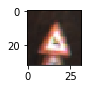

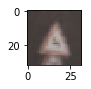

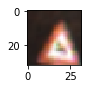

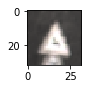

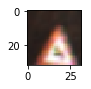

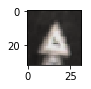

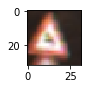

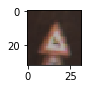

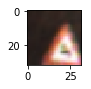

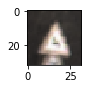

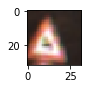

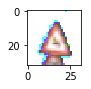

SystemExit: 1

/Users/yuanpingzhou/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [102]:
## visualization for image
def plot(image):
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap="gray")
    plt.show()
    
## brightness for image
def brightness(image):
    
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.0, upper=2.0)   
    image = tf.cast(image, tf.uint8)
    
    return image

def paintwhite(image):

    m1 = tf.cast(tf.less(image, tf.fill([32, 32, 3], np.uint8(60))), tf.uint8)
    white_img = tf.fill([32, 32, 3], np.uint8(255))
    
    image = tf.maximum(tf.cast(image, tf.int32), tf.cast(tf.multiply(white_img, m1), tf.int32))
    image = tf.cast(image, tf.uint8)
    
    return image

## scale for image
def scale(image):
    
    image = tf.divide(tf.cast(image, tf.float32), 255)
    image = tf.random_crop(image, size=[24, 24, 3])
    image = tf.image.resize_images(image, (32, 32))
    image = tf.cast(tf.multiply(image, 255.0), tf.uint8)
    
    return image

## augmentation for train images
def augment_data(dataset, dataset_labels, augementation_factor= 5):
    augmented_image = []
    augmented_image_labels = []

    img_input = tf.placeholder(tf.uint8, (32, 32, 3))
    # random brightness
    random_brightness = brightness(img_input)
    # scale
    scaling = scale(img_input)
    # painting
    painting = paintwhite(img_input)
    
    n = 0
    with tf.Session() as sess:
        for num in range (0, dataset.shape[0]):
            # original image
            augmented_image.append(dataset[num].tolist())
            augmented_image_labels.append(dataset_labels[num])
            for i in range(0, augementation_factor):
                # brightness for image
                result_img = sess.run(random_brightness, feed_dict= {img_input: dataset[num]})
                augmented_image.append(result_img.tolist())
                augmented_image_labels.append(dataset_labels[num])
                # nosing for image
                result_img = sess.run(scaling, feed_dict= {img_input: dataset[num]})
                augmented_image.append(result_img.tolist())
                augmented_image_labels.append(dataset_labels[num])
            # painting for image
            result_img = sess.run(painting, feed_dict= {img_input: dataset[num]})
            augmented_image.append(result_img.tolist())
            augmented_image_labels.append(dataset_labels[num])
            if((n % 1000) == 0):
                print('%s done.' % n)
            n += 1
    return np.array(augmented_image), np.array(augmented_image_labels)

print('original shape: ')
print(X_train.shape)
with timer('Augmentation ')
    X_train, y_train = augment_data(X_train, y_train)
print('augmented shape: ')
print(X_train.shape)

# label = 21
# idx = np.argwhere(y_train == label).flatten()
# print('size label %s is %s' % (label, len(idx)))
# print(X_train.shape)
# X_train_1 = X_train[idx,]
# y_train_1 = y_train[idx,]
# print(X_train_1.shape)

# tmp_x = X_train_1[:1,]
# tmp_y = y_train_1[:1,]
# print(tmp_x.shape)
# tmp_x, tmp_y = augment_data(tmp_x, tmp_y)
# print(tmp_x.shape)
# for i in range(len(tmp_x)):
#     plot(tmp_x[i])
# sys.exit(1)

In [ ]:
## visualization for image

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [ ]:
## LE-Net architechure
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. 
    # out_height = (32 - 5 + 1)/1 = 28,
    # out_width = (32 - 5 + 1)/1 = 28,
    # out_depth = 6(tunned)
    # Output = 28 * 28 * 6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. 
    # out_height = (28 - 2 + 2)/2 = 14,
    # out_width = (28 - 2 + 2)/2 = 14,
    # out_depth = 6(handed by conv1)
    # Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. 
    # out_height = (14 - 5 + 1)/1 = 10,
    # out_width = (14 - 5 + 1)/1 = 10,
    # out_depth = 16(tunned)
    # Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. 
    # out_height = (10 - 2 + 2)/2 = 5,
    # out_width = (10 - 2 + 2)/2 = 5,
    # out_depth = 16(handed by conv2)
    # Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16.
    # Output = 5 * 5 * 16 = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [ ]:
## super-parameters
rate = 0.001
EPOCHS = 10
BATCH_SIZE = 64

## TF logic for optimization 
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## TF logic for evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## training/evaluation
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

In [ ]:
## prediction on test
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

In [ ]:
## analysis with top-k softmax probabilities
import sys,os

softmax = tf.nn.softmax(logits)

k = 5
num_examples = len(X_test)
print(num_examples)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_test[offset:offset+BATCH_SIZE]
        if(offset == 0):
            pred_y = sess.run(softmax, feed_dict={x: batch_x})
        else:
            pred_y = np.vstack([pred_y, sess.run(softmax, feed_dict={x: batch_x})])
    topk = sess.run(tf.nn.top_k(tf.constant(pred_y), k= k))
    
    ## top-k softmax value
    print('softmax probabilities for top-%s' % k)
    print(topk.values[:10])
    
    flattened_topk = topk.indices.reshape(1, -1).tolist()[0]
    pred_dist = dict((i, 0.0) for i in range(43))
    for v in flattened_topk:
        pred_dist[v] += (1.0/(k * num_examples))
    encoded_y = sess.run(one_hot_y, feed_dict= {y: y_test})
    y_dist = (1.0 * np.sum(encoded_y, axis= 0))/num_examples
    print('\nDistribution for top-%s: ' % k)
    print([round(pred_dist[k], 4) for k in pred_dist])
    
    print('\nDistribution for truth: ')
    print([round(v, 4) for v in y_dist])

In [ ]:
def plot(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img, cmap="gray")
    plt.show()

## analysis with top-k lowest recall for individual labels
one_hot_pred = tf.one_hot(tf.argmax(softmax, 1), 43)
# y_pred_equal = tf.equal(one_hot_y, one_hot_pred)
y_pred_mult = tf.multiply(one_hot_y, one_hot_pred)
tp = tf.reduce_sum(y_pred_mult, 0)
t_n = tf.reduce_sum(one_hot_y, 0)

# collect top-k labels with lowest recall
k = 10
num_examples = len(X_test)
print('Total size for test %s ' % num_examples)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess.run(tf.local_variables_initializer())

    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_test[offset: offset + BATCH_SIZE]
        batch_y = y_test[offset: offset + BATCH_SIZE]
        if(offset == 0):
            tp_mat = sess.run(tp, feed_dict={x: batch_x, y: batch_y})
            t_n_mat = sess.run(t_n, feed_dict={x: batch_x, y: batch_y})
        else:
            tp_mat = np.vstack([tp_mat, sess.run(tp, feed_dict={x: batch_x, y: batch_y})])
            t_n_mat = np.vstack([t_n_mat, sess.run(t_n, feed_dict={x: batch_x, y: batch_y})])
    individual_recall = np.sum(tp_mat, 0) / np.sum(t_n_mat, 0)
    print('Recall for labels with the top-%s lowest recall: ' % k)
    topk_recall = np.sort(individual_recall[:k])
    print(topk_recall)
    print('Labels with the top-%s lowest recall: ' % k)
    topk_label = np.argsort(individual_recall)[:k]
    print(topk_label)   
# visualize some of these misclassified image
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    pred_mat = sess.run(one_hot_pred, feed_dict= {x: X_test})
    y_mat = sess.run(one_hot_y, feed_dict={y: y_test})
    
    y_pred_mult_mat = np.multiply(pred_mat, y_mat)
    # for label 27
    debug_label = 30
    print('\nDebug for label %s: ' % debug_label)
    pos_idx = np.argwhere(np.transpose(y_mat[:, debug_label]) == 1).flatten()
    pred_pos_idx = np.argwhere(np.transpose(pred_mat[:, debug_label]) == 1).flatten()
    
    print(pos_idx, pred_pos_idx)
    mis_pos_idx = [v for v in pos_idx if(v not in pred_pos_idx)]
    print('\nmisclassified index for label %s, size %s: ' % (debug_label, len(mis_pos_idx)))
    print(mis_pos_idx)
    mis_pred_label = np.argmax(pred_mat[mis_pos_idx,:], 1)
    print('\npredicted label for label %s: ' % debug_label)
    print(mis_pred_label)
    # sample the last 10 misclassified image, visualize them, see what characters they reside
    s = 5
    for i in range(s):
        img = X_test[mis_pos_idx[-(s - i)]].squeeze()
        plot(img)
        print('predicted label %s' % mis_pred_label[- (s - i)])
        
## simple summarization
# 1. nosing pixles, eg. misclassified as 25 for label 27
# 2. darkness, eg. misclassified as other labels for label 27
# 3. view distance
## improvement strategies
# 1. clips for image might help in some way
# 2. enlighten for image might be helpful
# 3. zoomming for image